# Ordinal Regression

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from scipy.stats._stats import _kendall_dis
from statsmodels.miscmodels.ordinal_model import OrderedModel
import warnings
warnings.filterwarnings("ignore")

def responseprofile(y):
    ydf = pd.DataFrame(y)
    ydf.columns = ['y'] 
    tata=pd.crosstab(index=ydf['y'], columns='count')
    tata[['count']]
    tata.index.name = 'values'
    tata.reset_index(inplace=True)
    the_table=pd.DataFrame(data=tata)
    the_table.columns = ['Ordered Values (y)' , 'Total Frequency']
    plt.subplot(212)
    plt.title('Response Profile',fontsize=20,y=1.7)
    plt.axis('off')
    plt.axis('tight')
    test2=plt.table(cellText=the_table.values, loc='center', cellLoc='center', colLabels=the_table.columns, colWidths=[0.4,0.4])
    test2.auto_set_font_size(False)
    test2.set_fontsize(16) 
    test2.scale(2, 1.7)
    
def convergence(y,logit_res): 
    val_listsetting = list(logit_res.mle_settings.values()) 
    val_listretvals = list(logit_res.mle_retvals.values()) 
    the_table2 = [ ['Optimizer',val_listsetting[0] ] ,   
                      ['Starting parameters', val_listsetting[1]],
                      ['Max. iterations', val_listsetting[2]], 
                      ['Tolerance rate', val_listsetting[9]],
                      ['Req. iterations', val_listretvals[3]],
                      ['Convergence Status', val_listretvals[6]]]
    the_table2=pd.DataFrame(data=the_table2)
    plt.subplot(212)
    plt.title('Model Convergence Status',fontsize=20,y=2)
    plt.axis('off')
    plt.axis('tight')
    test2=plt.table(cellText=the_table2.values, loc='center', cellLoc='center', colWidths=[0.4,0.8,0.4])

    cellDict = test2.get_celld()
    cellDict[(1,1)].set_height(.2)
    cellDict[(1,0)].set_height(.2)

    test2.auto_set_font_size(False)
    test2.set_fontsize(15) 
    test2.scale(2, 3)
    
    
def informationcriteria(y,logit_res):
    freqy=y.value_counts()
    m=len(freqy)
    the_table3 = [['AIC', np.round(-2*(logit_res.llnull-(m-1)),3),np.round(logit_res.aic,3)],
                      ['BIC', np.round(-2*logit_res.llnull+(m-1)*np.log(logit_res.nobs),3),np.round(logit_res.bic,3)], 
                      ['-2LogL', np.round(-2*logit_res.llnull,3),np.round(-2*logit_res.llf,3)]]
    the_table3=pd.DataFrame(data=the_table3)
    the_table3.columns = ['Criterion', 'Intercept Only', 'Intercept and Covariates']
    plt.subplot(311)
    plt.title('Information Criteria',fontsize=20, y=1.1)
    plt.axis('off')
    plt.axis('tight')
    test3=plt.table(cellText=the_table3.values, colLabels=the_table3.columns, loc='center', cellLoc='center', colWidths=[0.4,0.4,0.4])
    test3.auto_set_font_size(False)
    test3.set_fontsize(16) 
    test3.scale(2, 1.7)
    
def globalnull(y,logit_res):
    freqy=y.value_counts()
    m=len(freqy)
    M = np.identity(len(logit_res.params))
    M = M[:len(logit_res.params)-m+1,:]

    wald_global = logit_res.wald_test(M,scalar=False) 

    globalnull = [['Likelihood Ratio Test',round(logit_res.llr,4),round(logit_res.df_model)-m+1,round(logit_res.llr_pvalue,5)],
                 ['Wald',round(wald_global.statistic.item(),4), round(logit_res.df_model)-m+1,round(wald_global.pvalue.item(),5)]]
    globalnull=pd.DataFrame(data=globalnull)
    globalnull.columns = ['Test','Chi-Square','DF','Pr>ChiSq' ]
    plt.subplot(312)
    plt.title('Testing Global Null Hypothesis: BETA=0',fontsize=20)
    plt.axis('off')
    plt.axis('tight')
    test=plt.table(cellText=globalnull.values, colLabels=globalnull.columns, 
                   loc='center', cellLoc='center', colWidths=[0.3,0.2,0.2,0.2])
    test.auto_set_font_size(False)
    test.set_fontsize(18) 
    test.scale(2, 1.7)

def oddsratioestimates(y,logit_res):
    freqy=y.value_counts()
    m=len(freqy)
    params = logit_res.params[:len(logit_res.params)-m+1]
    conf = logit_res.conf_int()
    conf=conf.iloc[:len(logit_res.params)-m+1]
    confodr=np.exp(-conf)
    odr=np.exp(-params.to_frame())
    odr=odr.rename(columns={0:'Point Estimate'})
    confodr=confodr.rename(columns={0:'5%', 1:'95%'})
    table=pd.concat([odr[['Point Estimate']], confodr[['95%','5%']]], axis=1)
    plt.subplot(313)
    plt.title('Odds Ratio Estimates',fontsize=20,y=1.4)
    plt.axis('off')
    plt.axis('tight')
    table.update(table.astype(float))
    table.update(table.applymap('{:,.3f}'.format))
    test=plt.table(cellText=table.values, colLabels=['Point Estimate', 'Lower CI (95% Wald)','Upper CI (95% Wald)'],  
                   rowLabels=table.index, loc='center',cellLoc='center',colWidths=[0.3,0.35,0.35])
    plt.axis('off')
    test.auto_set_font_size(False)
    test.set_fontsize(20) 
    test.scale(2, 1.7)
    print('!!ATTENTION: Odds ratio are only OK with the Logit link function!!')
    
def associationstat(X, y, logit_res):    
    freqy=y.value_counts()
    m=len(freqy)
    
    N=len(y)
    cumtable=pd.concat([freqy, freqy.cumsum(), N-freqy.cumsum()], axis=1)
    totaltemp=cumtable[0]*cumtable[2]
    total=totaltemp.sum()
    
    Xmat = np.array(X)
    ymat=np.array(y)

    beta_hat=np.array(logit_res.params)
    beta_hat=beta_hat[:len(logit_res.params)-m+1]
    beta_hat
    #print(np.shape(Xmat))
    #print(np.shape(beta_hat))
    score_hat=Xmat.dot(beta_hat)                    
    x=score_hat
    
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()

    if x.size != y.size:
        raise ValueError("All inputs must be of the same size, "
                         "found x-size %s and y-size %s" % (x.size, y.size))

    def count_rank_tie(ranks):
        cnt = np.bincount(ranks).astype('int64', copy=False)
        cnt = cnt[cnt > 1]
        return ((cnt * (cnt - 1) // 2).sum(),
            (cnt * (cnt - 1.) * (cnt - 2)).sum(),
            (cnt * (cnt - 1.) * (2*cnt + 5)).sum())

    size = x.size
    perm = np.argsort(y)  # sort on y and convert y to dense ranks
    x, y = x[perm], y[perm]
    y = np.r_[True, y[1:] != y[:-1]].cumsum(dtype=np.intp)

    # stable sort on x and convert x to dense ranks
    perm = np.argsort(x, kind='mergesort')
    x, y = x[perm], y[perm]
    x = np.r_[True, x[1:] != x[:-1]].cumsum(dtype=np.intp)

    nd = _kendall_dis(x, y)  # discordant pairs

    obs = np.r_[True, (x[1:] != x[:-1]) | (y[1:] != y[:-1]), True]
    cnt = np.diff(np.where(obs)[0]).astype('int64', copy=False)

    ntie = (cnt * (cnt - 1) // 2).sum()  # joint ties
    xtie, x0, x1 = count_rank_tie(x)     # ties in x, stats
    ytie, y0, y1 = count_rank_tie(y)     # ties in y, stats

    tot = (size * (size - 1)) // 2
    
    nc = tot - nd - (xtie - ntie) - (ytie - ntie) - ntie
    
    val_listsetting = list(logit_res.mle_settings.values()) 
    val_listretvals = list(logit_res.mle_retvals.values()) 
    the_table = [ ['Percent Concordant',round(nc/total*100,2), 'Somers D',round((nc-nd)/total,3)],   
                      ['Percent Discordant', round(nd/total*100,2), 'Gamma',round((nc-nd)/(nc+nd),3)],
                      ['Percent Tied', round((total-nc-nd)/total*100,2), 'Tau-a', round((nc-nd)/(0.5*y.size*(y.size-1)),3)],
                      ['Pairs', round(total),'c',round((nc+0.5*(total-nc-nd))/total,3)]]
    the_table=pd.DataFrame(data=the_table)
    plt.subplot(221)
    plt.title('Association of Predicted Probabilities and Observed Responses',fontsize=20,y=0.95)
    plt.axis('off')
    plt.axis('tight')
    test=plt.table(cellText=the_table.values, loc='center', cellLoc='center', colWidths=[0.8,0.4,0.4,0.4,0.4])
    test.auto_set_font_size(False)
    test.set_fontsize(20) 
    test.scale(2, 1.7)

## 1. Data loading

In [5]:
# Getting the data
data = pd.read_excel("data.xlsx", sheet_name = 'Edited', index_col = None)
data

,INTERNET_USE,SCORE_PEOPLE_TRUST,SCORE_PEOPLE_FAIR,SAYING_IN_POLITICS,TRUST_LEGAL_SYSTEM,TRUST_POLICE,TRUST_POLITICIANS,SATISFACTION_LIFE,SATISFACTION_ECONOMY,SATISFACTION_GOVERNMENT,...,AGE,HAD_DIVORCED,MARITAL_STATUS,HAD_CHILDREN,DOMICILE,EDUCATION_YEARS,IS_WORKING,IS_STUDYING,IS_UNEMPLOYED,IS_RETIRED
0,4.0,2.0,3.0,1.0,6.0,7.0,4.0,8.0,4.0,7.0,...,38.0,0.0,1.0,NaN,4.0,13.0,0,0,0,0
1,5.0,5.0,5.0,4.0,NaN,7.0,NaN,NaN,NaN,7.0,...,17.0,0.0,6.0,0.0,4.0,10.0,0,0,0,0
2,5.0,4.0,4.0,2.0,7.0,6.0,5.0,8.0,5.0,5.0,...,28.0,0.0,6.0,0.0,3.0,15.0,1,0,0,0
3,5.0,6.0,6.0,2.0,8.0,6.0,5.0,8.0,4.0,6.0,...,29.0,0.0,6.0,0.0,4.0,20.0,1,0,0,0
4,5.0,2.0,3.0,3.0,5.0,8.0,0.0,7.0,5.0,9.0,...,45.0,0.0,1.0,NaN,4.0,8.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740,3.0,2.0,7.0,2.0,5.0,7.0,0.0,10.0,3.0,1.0,...,75.0,0.0,5.0,0.0,3.0,5.0,0,0,0,1
2741,1.0,4.0,5.0,1.0,3.0,6.0,0.0,6.0,5.0,5.0,...,NaN,0.0,1.0,1.0,4.0,13.0,0,0,0,1
2742,5.0,5.0,5.0,3.0,8.0,7.0,3.0,8.0,4.0,3.0,...,67.0,0.0,1.0,NaN,3.0,13.0,0,0,0,1
2743,5.0,2.0,5.0,2.0,5.0,7.0,4.0,9.0,5.0,6.0,...,18.0,0.0,6.0,0.0,3.0,12.0,0,1,0,0


## 2. Preprocessing

Aggregating the dependent variables into four buckets.

In [6]:
#Getting in three threshold for our independent variable - "SCORE_HAPPY"
data["HAPPY"] = pd.cut(data.SCORE_HAPPY, [0, 6, 7, 8, 10], labels = [1, 2, 3, 4])

# Number of observations per bucket
data.HAPPY.value_counts().sort_index()

1    782
2    692
3    790
4    445
Name: HAPPY, dtype: int64

Turning MARITAL_STATUS into categorical:

In [7]:
data = pd.get_dummies(data=data, columns=["MARITAL_STATUS", "DOMICILE"], dummy_na=True, drop_first=True)

In [8]:
#Understanding the total number of null values in our dataset
data.isnull().sum().sort_values(ascending = False)

HAD_CHILDREN                 984
SATISFACTION_GOVERNMENT      163
ASHAMED_LGBTQ                139
SATISFACTION_DEMOCRACY       127
SAYING_IN_POLITICS           112
SATISFACTION_EDUCATION        97
SATISFACTION_ECONOMY          97
EDUCATION_YEARS               85
TRUST_POLITICIANS             79
IMMIGRANTS_COUNTRY_BETTER     78
TRUST_LEGAL_SYSTEM            74
IS_DISCRIMINATED_GROUP        56
SCORE_ATTACHED_EUROPE         55
PEOPLE_IN_HOUSEHOLD           50
PEOPLE_TO_DISCUSS             50
SOCIAL_ACTIVITIES             38
HAPPY                         36
SATISFACTION_HEALTH           33
SATISFACTION_LIFE             33
TRUST_POLICE                  31
HAD_DIVORCED                  28
SCORE_PEOPLE_FAIR             25
AGE                           21
SCORE_DISABLE                 21
SCORE_ATTACHED_COUNTRY        15
MEET_FRIENDS                  12
SCORE_HAPPY                   12
SCORE_HEALTHY                  9
SCORE_PEOPLE_TRUST             9
INTERNET_USE                   5
IS_FEMALE 

Dropping the NAs

In [9]:
#Making a copy of our original dataset before we clean the null values.
data1 = data.copy()

#Removing the null values for the first iteration to run a preliminary ordinal regression and understand the significant variables.
data1.dropna(axis = 0, inplace = True)
#resetting the index to deal with the missing values
data1.reset_index(inplace = True, drop=True)
data1.head()

,INTERNET_USE,SCORE_PEOPLE_TRUST,SCORE_PEOPLE_FAIR,SAYING_IN_POLITICS,TRUST_LEGAL_SYSTEM,TRUST_POLICE,TRUST_POLITICIANS,SATISFACTION_LIFE,SATISFACTION_ECONOMY,SATISFACTION_GOVERNMENT,...,MARITAL_STATUS_3.0,MARITAL_STATUS_4.0,MARITAL_STATUS_5.0,MARITAL_STATUS_6.0,MARITAL_STATUS_nan,DOMICILE_2.0,DOMICILE_3.0,DOMICILE_4.0,DOMICILE_5.0,DOMICILE_nan
0,5.0,4.0,4.0,2.0,7.0,6.0,5.0,8.0,5.0,5.0,...,0,0,0,1,0,0,1,0,0,0
1,5.0,6.0,6.0,2.0,8.0,6.0,5.0,8.0,4.0,6.0,...,0,0,0,1,0,0,0,1,0,0
2,2.0,5.0,4.0,2.0,5.0,8.0,5.0,3.0,5.0,5.0,...,0,0,0,1,0,0,0,1,0,0
3,4.0,7.0,7.0,2.0,6.0,8.0,4.0,6.0,4.0,5.0,...,0,0,0,1,0,0,1,0,0,0
4,5.0,7.0,6.0,2.0,4.0,6.0,3.0,8.0,3.0,6.0,...,0,0,0,1,0,0,0,1,0,0


In [10]:
Y_in = data1["HAPPY"]
X_in = data1.loc[:, ~data1.columns.isin(['SCORE_HAPPY','HAPPY'])]

## 3. First iteration of the Ordinal Model

In [11]:
ordinal_model1 = OrderedModel(Y_in, X_in, distr='logit').fit(method='bfgs')
ordinal_model1.summary()

Optimization terminated successfully.
         Current function value: 0.996844
         Iterations: 201
         Function evaluations: 205
         Gradient evaluations: 205


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  HAPPY   Log-Likelihood:                -1278.0
Model:                   OrderedModel   AIC:                             2652.
Method:            Maximum Likelihood   BIC:                             2899.
Date:                Tue, 15 Mar 2022                                         
Time:                        16:42:32                                         
No. Observations:                1282                                         
Df Residuals:                    1234                                         
Df Model:                          48                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
INTERNET_USE                  0.0479      0.056      0.854      0.393      -0.062       0.158
SCORE_PEOPLE_TRUST            0.0228      0.035      0.650      0.516      -0.046       0.092
SCORE_PEOPLE_FAIR            -0.0034      0.036     -0.093      0.926      -0.074       0.068
SAYING_IN_POLITICS           -0.0103      0.090     -0.114      0.909      -0.187       0.167
TRUST_LEGAL_SYSTEM           -0.0164      0.036     -0.459      0.647      -0.087       0.054
TRUST_POLICE                  0.0414      0.039      1.062      0.288      -0.035       0.118
TRUST_POLITICIANS            -0.0095      0.033     -0.285      0.776      -0.075       0.056
SATISFACTION_LIFE             0.9730      0.051     18.929      0.000       0.872       1.074
SATISFACTION_ECONOMY          0.0128      0.038      0.339      0.735      -0.061       0.087
SATISFACTION_GOVERNMENT      -0.0248      0.034     -0.725      0.469      -0.092       0.042
SATISFACTION_DEMOCRACY       -0.0247      0.039     -0.635      0.526      -0.101       0.052
SATISFACTION_EDUCATION        0.0076      0.039      0.196      0.845      -0.068       0.083
SATISFACTION_HEALTH           0.0407      0.033      1.236      0.217      -0.024       0.105
ASHAMED_LGBTQ                 0.0521      0.056      0.936      0.349      -0.057       0.161
IMMIGRANTS_COUNTRY_BETTER     0.0403      0.030      1.350      0.177      -0.018       0.099
MEET_FRIENDS                  0.1410      0.048      2.942      0.003       0.047       0.235
PEOPLE_TO_DISCUSS             0.0545      0.047      1.159      0.247      -0.038       0.147
SOCIAL_ACTIVITIES             0.1687      0.113      1.488      0.137      -0.053       0.391
SCORE_HEALTHY                -0.3224      0.100     -3.221      0.001      -0.519      -0.126
SCORE_DISABLE                -0.1382      0.182     -0.761      0.447      -0.494       0.218
SCORE_ATTACHED_COUNTRY        0.1113      0.037      3.019      0.003       0.039       0.184
SCORE_ATTACHED_EUROPE         0.1108      0.027      4.041      0.000       0.057       0.165
IS_DISCRIMINATED_GROUP       -0.1230      0.332     -0.371      0.711      -0.773       0.527
FUTURE_PLANNING               0.0077      0.022      0.343      0.732      -0.036       0.052
PEOPLE_IN_HOUSEHOLD           0.0066      0.076      0.086      0.931      -0.143       0.156
IS_FEMALE                    -0.1336      0.117     -1.143      0.253      -0.363       0.095
AGE                          -0.0046      0.007     -0.641      0.521      -0.019       0.009
HAD_DIVORCED                  0.4108      0.396      1.037      0.300      -0.365       1.187
HAD_CHILDREN                  0.1233      0.162      0.763      0.446      -0.194       0.440
EDUCATION_YEARS              -0.0089      0.017     -0.538      0.591      -0.042       0.024
IS_WORKING                   -0.3588      0.228     -1.577  

Filtering the significant variables:

In [12]:
coefs_ordinal = pd.DataFrame({
    'coef': ordinal_model1.params.values,
    'pvalue': ordinal_model1.pvalues,
}).sort_values(by='pvalue', ascending=False)
coefs_ordinal.round(4)

,coef,pvalue
PEOPLE_IN_HOUSEHOLD,0.0066,0.9313
SCORE_PEOPLE_FAIR,-0.0034,0.9263
DOMICILE_nan,15.1531,0.9201
SAYING_IN_POLITICS,-0.0103,0.9090
SATISFACTION_EDUCATION,0.0076,0.8445
TRUST_POLITICIANS,-0.0095,0.7758
SATISFACTION_ECONOMY,0.0128,0.7347
FUTURE_PLANNING,0.0077,0.7319
IS_DISCRIMINATED_GROUP,-0.1230,0.7108
IS_STUDYING,-0.1315,0.6567


In [13]:
#Removing the insignificant variables
significant_variables = list(coefs_ordinal[coefs_ordinal['pvalue'] <= 0.10].index)
significant_variables

['DOMICILE_2.0',
 'DOMICILE_5.0',
 'DOMICILE_4.0',
 'DOMICILE_3.0',
 'MEET_FRIENDS',
 'SCORE_ATTACHED_COUNTRY',
 'SCORE_HEALTHY',
 'SCORE_ATTACHED_EUROPE',
 '1/2',
 '2/3',
 '3/4',
 'SATISFACTION_LIFE']

In [14]:
# Removing the threshold coefficients
for val in ['1/2', '2/3', '3/4']:
    significant_variables.remove(val)

In [15]:
#Final list of significant variables
significant_variables

['DOMICILE_2.0',
 'DOMICILE_5.0',
 'DOMICILE_4.0',
 'DOMICILE_3.0',
 'MEET_FRIENDS',
 'SCORE_ATTACHED_COUNTRY',
 'SCORE_HEALTHY',
 'SCORE_ATTACHED_EUROPE',
 'SATISFACTION_LIFE']

We now run a second iteration with the significant variables and the original dataset to understand if there are any further insignificant variables that we need to remove.

The threshold chosen for the significance is 10% as there is the chance that some variables being slightly past the 5% mark might stabilize when some of the noise added by the more openly irrelevant variables is removed.

## 4. Second Iteration of the Ordinal Model

Now we have obtained all the significant variables which are explanatory to the final HAPPY values. We keep focusing on them and try to fit a new ordinal regression. We extract required data from the original dataset and do the same pre-processing as in model_1.

In [16]:
data_restricted = data.loc[:, significant_variables].copy()
data_restricted["HAPPY"] = data["HAPPY"]
print(data_restricted.isnull().sum().sort_values(ascending = False))

#Dropping the null values
data_restricted.dropna(axis = 0, inplace = True)

SCORE_ATTACHED_EUROPE     55
HAPPY                     36
SATISFACTION_LIFE         33
SCORE_ATTACHED_COUNTRY    15
MEET_FRIENDS              12
SCORE_HEALTHY              9
DOMICILE_2.0               0
DOMICILE_5.0               0
DOMICILE_4.0               0
DOMICILE_3.0               0
dtype: int64


We are now ready to run the new model:

In [17]:
Y_in_2 = data_restricted["HAPPY"]
X_in_2 = data_restricted.loc[:, ~data_restricted.columns.isin(['HAPPY'])]

ordinal_model2 = OrderedModel(Y_in_2, X_in_2, distr='logit').fit(method='bfgs')
ordinal_model2.summary()

Optimization terminated successfully.
         Current function value: 1.003599
         Iterations: 46
         Function evaluations: 49
         Gradient evaluations: 49


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  HAPPY   Log-Likelihood:                -2637.5
Model:                   OrderedModel   AIC:                             5299.
Method:            Maximum Likelihood   BIC:                             5369.
Date:                Tue, 15 Mar 2022                                         
Time:                        16:43:01                                         
No. Observations:                2628                                         
Df Residuals:                    2616                                         
Df Model:                          12                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
DOMICILE_2.0               0.2957      0.201      1.474      0.140      -0.097       0.689
DOMICILE_5.0               0.2530      0.225      1.124      0.261      -0.188       0.694
DOMICILE_4.0               0.2790      0.125      2.228      0.026       0.034       0.525
DOMICILE_3.0               0.2593      0.128      2.025      0.043       0.008       0.510
MEET_FRIENDS               0.1453      0.028      5.235      0.000       0.091       0.200
SCORE_ATTACHED_COUNTRY     0.0875      0.024      3.632      0.000       0.040       0.135
SCORE_HEALTHY             -0.3589      0.052     -6.942      0.000      -0.460      -0.258
SCORE_ATTACHED_EUROPE      0.1070      0.017      6.341      0.000       0.074       0.140
SATISFACTION_LIFE          1.0438      0.035     29.765      0.000       0.975       1.113
1/2                        7.3263      0.373     19.663      0.000       6.596       8.057
2/3                        0.6353      0.035     18.021      0.000       0.566       0.704
3/4                        0.8198      0.032     25.314      0.000       0.756       0.883
==========================================================================================
"""

In [18]:
coefs_ordinal2 = pd.DataFrame({
    'coef': ordinal_model2.params.values,
    'pvalue': ordinal_model2.pvalues,
}).sort_values(by='pvalue', ascending=False)
coefs_ordinal2.round(4)

,coef,pvalue
DOMICILE_5.0,0.2530,0.2610
DOMICILE_2.0,0.2957,0.1404
DOMICILE_3.0,0.2593,0.0428
DOMICILE_4.0,0.2790,0.0259
SCORE_ATTACHED_COUNTRY,0.0875,0.0003
MEET_FRIENDS,0.1453,0.0000
SCORE_ATTACHED_EUROPE,0.1070,0.0000
SCORE_HEALTHY,-0.3589,0.0000
2/3,0.6353,0.0000
1/2,7.3263,0.0000


In [19]:
#Removing the insignificant variables
significant_variables2 = list(coefs_ordinal2[coefs_ordinal2['pvalue'] <= 0.10].index)
significant_variables2

# Removing the threshold coefficients
for val in ['1/2', '2/3', '3/4']:
    significant_variables2.remove(val)
significant_variables2

['DOMICILE_3.0',
 'DOMICILE_4.0',
 'SCORE_ATTACHED_COUNTRY',
 'MEET_FRIENDS',
 'SCORE_ATTACHED_EUROPE',
 'SCORE_HEALTHY',
 'SATISFACTION_LIFE']

## 5. Third iterations of the Ordinary Model

In [20]:
data_restricted = data.loc[:, significant_variables2].copy()
data_restricted["HAPPY"] = data["HAPPY"]
print(data_restricted.isnull().sum().sort_values(ascending = False))

#Dropping the null values
data_restricted.dropna(axis = 0, inplace = True)

SCORE_ATTACHED_EUROPE     55
HAPPY                     36
SATISFACTION_LIFE         33
SCORE_ATTACHED_COUNTRY    15
MEET_FRIENDS              12
SCORE_HEALTHY              9
DOMICILE_3.0               0
DOMICILE_4.0               0
dtype: int64


In [21]:
Y_in_3 = data_restricted["HAPPY"]
X_in_3 = data_restricted.loc[:, ~data_restricted.columns.isin(['HAPPY'])]

ordinal_model3 = OrderedModel(Y_in_3, X_in_3, distr='logit').fit(method='bfgs')
ordinal_model3.summary()

Optimization terminated successfully.
         Current function value: 1.004121
         Iterations: 34
         Function evaluations: 37
         Gradient evaluations: 37


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  HAPPY   Log-Likelihood:                -2638.8
Model:                   OrderedModel   AIC:                             5298.
Method:            Maximum Likelihood   BIC:                             5356.
Date:                Tue, 15 Mar 2022                                         
Time:                        16:43:32                                         
No. Observations:                2628                                         
Df Residuals:                    2618                                         
Df Model:                          10                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
DOMICILE_3.0               0.1403      0.106      1.329      0.184      -0.067       0.347
DOMICILE_4.0               0.1603      0.102      1.567      0.117      -0.040       0.361
SCORE_ATTACHED_COUNTRY     0.0867      0.024      3.598      0.000       0.039       0.134
MEET_FRIENDS               0.1471      0.028      5.305      0.000       0.093       0.201
SCORE_ATTACHED_EUROPE      0.1063      0.017      6.310      0.000       0.073       0.139
SCORE_HEALTHY             -0.3601      0.052     -6.967      0.000      -0.461      -0.259
SATISFACTION_LIFE          1.0433      0.035     29.754      0.000       0.975       1.112
1/2                        7.2013      0.364     19.765      0.000       6.487       7.915
2/3                        0.6349      0.035     18.012      0.000       0.566       0.704
3/4                        0.8181      0.032     25.269      0.000       0.755       0.882
==========================================================================================
"""

In [22]:
coefs_ordinal3 = pd.DataFrame({
    'coef': ordinal_model3.params.values,
    'pvalue': ordinal_model3.pvalues,
}).sort_values(by='pvalue', ascending=False)
coefs_ordinal3.round(4)

,coef,pvalue
DOMICILE_3.0,0.1403,0.1840
DOMICILE_4.0,0.1603,0.1172
SCORE_ATTACHED_COUNTRY,0.0867,0.0003
MEET_FRIENDS,0.1471,0.0000
SCORE_ATTACHED_EUROPE,0.1063,0.0000
SCORE_HEALTHY,-0.3601,0.0000
2/3,0.6349,0.0000
1/2,7.2013,0.0000
3/4,0.8181,0.0000
SATISFACTION_LIFE,1.0433,0.0000


In [23]:
#Removing the insignificant variables
significant_variables3 = list(coefs_ordinal3[coefs_ordinal3['pvalue'] <= 0.10].index)
significant_variables3

# Removing the threshold coefficients
for val in ['1/2', '2/3', '3/4']:
    significant_variables3.remove(val)

## 6. Fourth Iteration of the Ordinary Model

In [24]:
data_restricted = data.loc[:, significant_variables3].copy()
data_restricted["HAPPY"] = data["HAPPY"]
print(data_restricted.isnull().sum().sort_values(ascending = False))

#Dropping the null values
data_restricted.dropna(axis = 0, inplace = True)

SCORE_ATTACHED_EUROPE     55
HAPPY                     36
SATISFACTION_LIFE         33
SCORE_ATTACHED_COUNTRY    15
MEET_FRIENDS              12
SCORE_HEALTHY              9
dtype: int64


In [25]:
Y_in_4 = data_restricted["HAPPY"]
X_in_4 = data_restricted.loc[:, ~data_restricted.columns.isin(['HAPPY'])]

ordinal_model4 = OrderedModel(Y_in_4, X_in_4, distr='logit').fit(method='bfgs')
ordinal_model4.summary()

Optimization terminated successfully.
         Current function value: 1.004622
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  HAPPY   Log-Likelihood:                -2640.1
Model:                   OrderedModel   AIC:                             5296.
Method:            Maximum Likelihood   BIC:                             5343.
Date:                Tue, 15 Mar 2022                                         
Time:                        16:44:03                                         
No. Observations:                2628                                         
Df Residuals:                    2620                                         
Df Model:                           8                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
SCORE_ATTACHED_COUNTRY     0.0867      0.024      3.598      0.000       0.039       0.134
MEET_FRIENDS               0.1464      0.028      5.287      0.000       0.092       0.201
SCORE_ATTACHED_EUROPE      0.1056      0.017      6.270      0.000       0.073       0.139
SCORE_HEALTHY             -0.3635      0.052     -7.036      0.000      -0.465      -0.262
SATISFACTION_LIFE          1.0449      0.035     29.799      0.000       0.976       1.114
1/2                        7.0814      0.356     19.871      0.000       6.383       7.780
2/3                        0.6339      0.035     17.985      0.000       0.565       0.703
3/4                        0.8174      0.032     25.250      0.000       0.754       0.881
==========================================================================================
"""

### *9. Statistical metrics for ordinal regression*

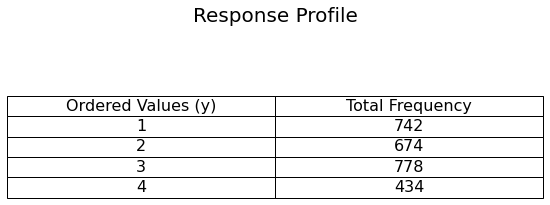

In [26]:
responseprofile(Y_in_4)

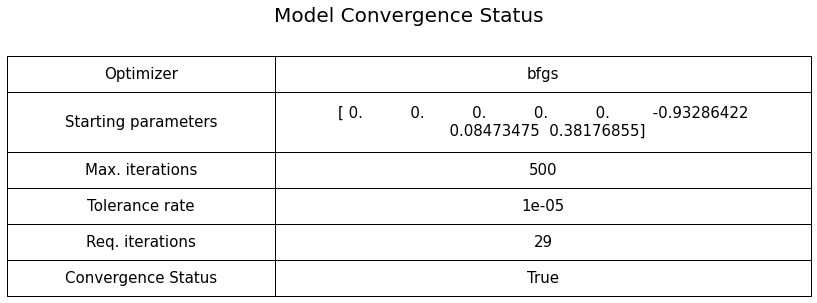

In [27]:
convergence(Y_in_4,ordinal_model4)

#### *Green flag! We can keep working on our analysis. Before we do that, we reset index of our trainning dataset and testing dataset to make all the things readable.*

In [124]:
X_train2.reset_index(inplace = True)
X_train2.drop(columns = ['index'], axis = 1, inplace = True)

In [125]:
Y_train2 = pd.DataFrame(Y_train2)
Y_train2.reset_index(inplace = True)
Y_train2.drop(columns = ['index'], axis = 1, inplace = True)

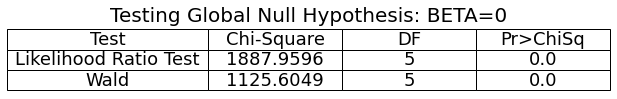

In [28]:
globalnull(Y_in_4,ordinal_model4)

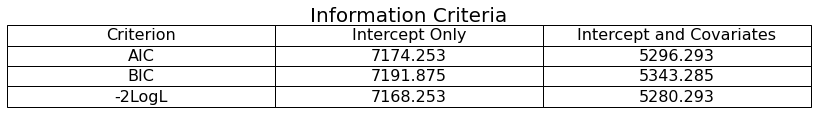

In [29]:
informationcriteria(Y_in_4,ordinal_model4)

#### *Our regression model has better performance than the model with only intercepts. We are using explanatory variables!*

In [32]:
X_in_4.reset_index(inplace = True)
X_in_4.drop(columns = ['index'], axis = 1, inplace = True)

In [33]:
Y_in_4 = pd.DataFrame(Y_in_4)
Y_in_4.reset_index(inplace = True)
Y_in_4.drop(columns = ['index'], axis = 1, inplace = True)

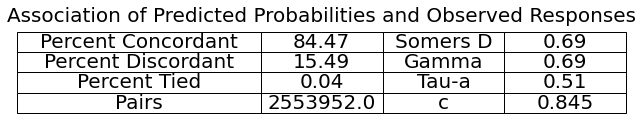

In [34]:
associationstat(X_in_4, Y_in_4, ordinal_model4)

#### *Our model is obviously better than a random model.*

!!ATTENTION: Odds ratio are only OK with the Logit link function!!


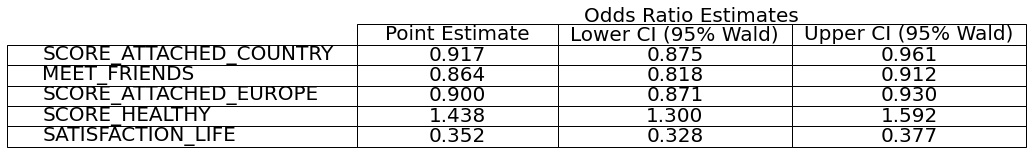

In [30]:
oddsratioestimates(Y_in_4, ordinal_model4)

#### *All the six variables we use are significant regarding the odds ratio since 1 is not in each of the intervals.*

### *END OF FILE*